# Загрузка данных

In [74]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

from catboost import CatBoostRegressor

import pickle

In [75]:
# Загрузка данных с дополнительными признаками
df = pd.read_csv('to-modal.csv', parse_dates=['dt'], index_col='dt')

# Построение модели

## catboost

для того, чтобы модель могла лучше учитывать временные данные, создаю лаги

In [76]:
# создание лагов и удаление пропущенных значений, которые создаются вместе в них (на всякий случай создаю больше, чем 1 и 2)
for lag in [1, 2, 3, 6, 12]:
    df[f'lag_{lag}'] = df['Цена на арматуру'].shift(lag)
    
df = df.dropna()

In [77]:
# разделение на обучающую и тестовую выборки в процентном соотношении 80 к 20
train_size = int(len(df) * 0.85)
train, test = df.iloc[:train_size], df.iloc[train_size:]

X_train, y_train = train.drop(columns=['Цена на арматуру']), train['Цена на арматуру']
X_test, y_test = test.drop(columns=['Цена на арматуру']), test['Цена на арматуру']

In [78]:
# cоздание и обучение модели
model = CatBoostRegressor(iterations=5000, 
                          learning_rate=0.01, 
                          depth=1, 
                          loss_function='MAE',
                          has_time=True,
                          early_stopping_rounds=100)

model.fit(X_train, y_train)

# прогнозирование
predictions = model.predict(X_test)

0:	learn: 8323.1529744	total: 1.17ms	remaining: 5.86s
1:	learn: 8282.1231595	total: 1.78ms	remaining: 4.44s
2:	learn: 8240.7729687	total: 2.24ms	remaining: 3.74s
3:	learn: 8200.5468380	total: 2.95ms	remaining: 3.68s
4:	learn: 8161.1420688	total: 3.55ms	remaining: 3.55s
5:	learn: 8123.4085989	total: 3.99ms	remaining: 3.32s
6:	learn: 8086.7558838	total: 4.48ms	remaining: 3.2s
7:	learn: 8051.2393493	total: 5.04ms	remaining: 3.15s
8:	learn: 8013.6495221	total: 5.66ms	remaining: 3.14s
9:	learn: 7981.4367905	total: 6.13ms	remaining: 3.06s
10:	learn: 7946.2883128	total: 6.59ms	remaining: 2.99s
11:	learn: 7910.0223012	total: 7.69ms	remaining: 3.2s
12:	learn: 7874.6583442	total: 8.79ms	remaining: 3.37s
13:	learn: 7842.6783775	total: 9.52ms	remaining: 3.39s
14:	learn: 7807.6899195	total: 10.2ms	remaining: 3.39s
15:	learn: 7775.2837793	total: 10.8ms	remaining: 3.35s
16:	learn: 7750.2681638	total: 11.4ms	remaining: 3.34s
17:	learn: 7717.5857581	total: 11.9ms	remaining: 3.29s
18:	learn: 7685.432091

In [79]:
# оценка модели с помощью метрик
mape = mean_absolute_percentage_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}")
print(f"MAE: {mae:.2f}")

R²: 0.7680
MAPE: 0.07
MAE: 3627.29


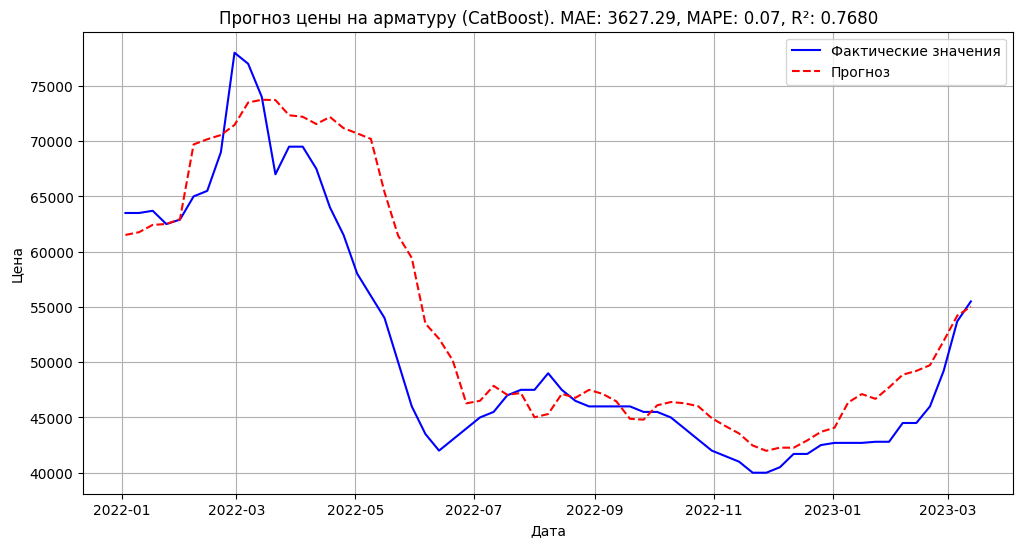

In [80]:
# визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Фактические значения', color='blue')
plt.plot(test.index, predictions, label='Прогноз', color='red', linestyle='--')
plt.title(f'Прогноз цены на арматуру (CatBoost). MAE: {mae:.2f}, MAPE: {mape:.2f}, R²: {r2:.4f}')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

Теперь попробую на основании данных из отработанной модели выбрать самые значимые признаки и обучить модель заново - иногда наименее важные признаки только ухудшают прогноз, поэтому попробую выбать 15 самых значимых:

In [81]:
# получаем важность признаков из модели
feature_importance = model.feature_importances_

# сортируем индексы по убыванию важности
sorted_idx = np.argsort(feature_importance)[::-1]

# выбираем топ-15 индексов
top_n = 15
top_feature_indices = sorted_idx[:top_n]

# получаем имена топ-признаков
top_features = X_train.columns[top_feature_indices].tolist()
# создаем новый датасет с отобранными признаками
X_selected = X_train[top_features]

print("Топ-15 признаков:", top_features)
X_selected

Топ-15 признаков: ['lag_1', 'lag_2', 'ГБЖ_CFR Италия, $/т', 'Лом_3А, FOB РФ Черное море, $/т', 'lag_3', 'Чугун_CFR Турция, $/т', 'Лом_HMS 1/2 80:20, FOB США Восток, $/т', 'Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т', 'ЖРС_Украинские окатыши Fe 65-66%, DAP граница Украины с Европой,  $/т', 'Лом_HMS 1/2 80:20, CFR Турция, $/т', 'Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС', 'Чугун_FOB Бразилия Север, $/т', 'Чугун_Россия, FCA руб./т, без НДС', 'Лом_HMS 1/2 80:20, CFR ЮВА, $/т', 'ЖРС_Россия окатыши Fe 62-65,5% FCA руб./т, без НДС']


,lag_1,lag_2,"ГБЖ_CFR Италия, $/т","Лом_3А, FOB РФ Черное море, $/т",lag_3,"Чугун_CFR Турция, $/т","Лом_HMS 1/2 80:20, FOB США Восток, $/т","Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т","ЖРС_Украинские окатыши Fe 65-66%, DAP граница Украины с Европой, $/т","Лом_HMS 1/2 80:20, CFR Турция, $/т","Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС","Чугун_FOB Бразилия Север, $/т","Чугун_Россия, FCA руб./т, без НДС","Лом_HMS 1/2 80:20, CFR ЮВА, $/т","ЖРС_Россия окатыши Fe 62-65,5% FCA руб./т, без НДС"
dt,,,,,,,,,,,,,,,
2015-03-30,27800.0,28700.0,249.5,221.0,29000.0,297.5,233.0,231.0,125.5,256.0,11853.0,269.0,15250.0,254.0,3500.0
2015-04-06,27200.0,27800.0,249.5,229.0,28700.0,297.5,236.0,235.0,125.5,262.0,11785.0,265.0,13250.0,258.0,3200.0
2015-04-13,26600.0,27200.0,249.5,229.0,27800.0,297.5,236.0,238.0,125.5,263.0,11327.0,265.0,13250.0,258.0,3200.0
2015-04-20,25700.0,26600.0,249.5,238.0,27200.0,297.5,241.0,245.0,125.5,267.0,11050.0,265.0,13250.0,258.0,3200.0
2015-04-27,24800.0,25700.0,249.5,243.0,26600.0,297.5,248.0,250.0,125.5,274.0,11091.0,270.0,13250.0,258.0,3200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-29,72500.0,78000.0,492.5,438.0,79000.0,571.5,453.0,438.0,137.0,492.0,26133.0,510.0,39250.0,530.0,10550.0
2021-12-06,64000.0,72500.0,482.5,428.0,78000.0,560.0,445.0,430.0,137.0,484.0,26178.0,510.0,39250.0,530.0,8950.0
2021-12-13,61500.0,64000.0,467.5,415.0,72500.0,545.0,431.0,417.0,137.0,471.0,26031.0,510.0,39250.0,528.0,8950.0


In [82]:
# обучаю модель на новых данных
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          early_stopping_rounds=100)

0:	learn: 8323.1529744	test: 16589.5952382	best: 16589.5952382 (0)	total: 539us	remaining: 2.7s
1:	learn: 8282.1231595	test: 16541.0802393	best: 16541.0802393 (1)	total: 926us	remaining: 2.31s
2:	learn: 8240.7729687	test: 16493.5503917	best: 16493.5503917 (2)	total: 1.23ms	remaining: 2.04s
3:	learn: 8200.5468380	test: 16446.4958420	best: 16446.4958420 (3)	total: 1.5ms	remaining: 1.87s
4:	learn: 8161.1420688	test: 16401.4118391	best: 16401.4118391 (4)	total: 1.81ms	remaining: 1.81s
5:	learn: 8123.4085989	test: 16353.7786761	best: 16353.7786761 (5)	total: 2.1ms	remaining: 1.75s
6:	learn: 8086.7558838	test: 16302.6218413	best: 16302.6218413 (6)	total: 2.38ms	remaining: 1.7s
7:	learn: 8051.2393493	test: 16251.9765787	best: 16251.9765787 (7)	total: 2.73ms	remaining: 1.7s
8:	learn: 8013.6495221	test: 16208.8377662	best: 16208.8377662 (8)	total: 3.06ms	remaining: 1.7s
9:	learn: 7981.4367905	test: 16161.1303405	best: 16161.1303405 (9)	total: 3.58ms	remaining: 1.79s
10:	learn: 7946.2883128	test

In [83]:
# получаем новые предсказания
predictions = model.predict(X_test)

In [84]:
# оценка модели с помощью метрик
mape = mean_absolute_percentage_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}")
print(f"MAE: {mae:.2f}")

R²: 0.7971
MAPE: 0.07
MAE: 3389.43


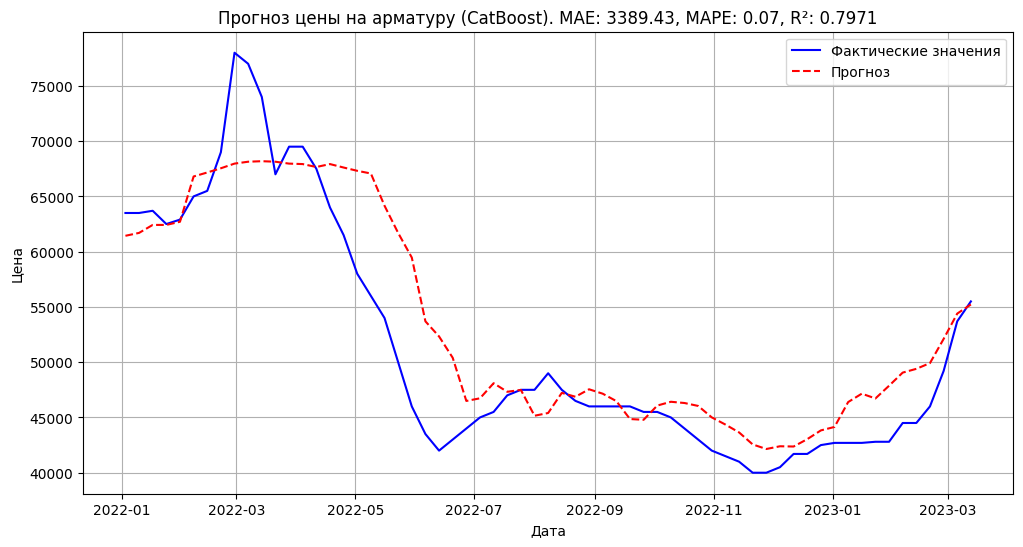

In [85]:
# визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Фактические значения', color='blue')
plt.plot(test.index, predictions, label='Прогноз', color='red', linestyle='--')
plt.title(f'Прогноз цены на арматуру (CatBoost). MAE: {mae:.2f}, MAPE: {mape:.2f}, R²: {r2:.4f}')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

после выбора наиболее влияющих признаков модель стала выдавать резульаты лучше, чем в первый раз. Из этого можно сделать вывод, что всего 15 дополнительным параметрам хватает модели, чтобы обучиться лучше.

In [86]:

with open('catboost_model.pkl', 'wb') as f: pickle.dump(model, f)